<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/umbcdata602/fall2020/blob/master/lab_tensorflow_linear_regression.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab -- tensorflow linear regression

* This lab builds from ch13_part2.ipynb
* Chapter 13 (p450) uses tensorflow to fit a line with least squares
* Goals
    * fit a parabola (add nonlinearity to the model)
    * practice with tensorflow datasets
    * practice with GradientTape
    * hyperparameter tuning, learning, visualizing weights

Ref: [Raschka ch13_part2.ipynb](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch13/ch13_part2.ipynb) -- github

# Create the dataset

In [1]:
# Cell 3
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

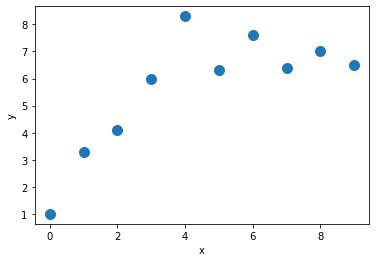

In [2]:
# Cell 4 -- data slightly modified from ch13_part2.ipynb
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 3.3, 4.1,
                    6.0, 8.3, 6.3,
                    7.6, 6.4, 7.0,
                    6.5])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Tensorflow dataset

In [3]:
# Cell 5
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [4]:
for element in ds_train_orig:
    pass

In [5]:
ds_new = ds_train_orig.batch(batch_size=3, drop_remainder=False)
for X, y in ds_new:
    pass

# Define the model with keras


In [6]:
# Cell 6
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Cell 7
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

# Introducing GradientTape


In [8]:
# This example is from the tensorflow API docs
# https://www.tensorflow.org/api_docs/python/tf/GradientTape
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x) # Will compute to 6.0
print('type(x):', type(x))
print('type(y):', type(y))
dy_dx

type(x): <class 'tensorflow.python.framework.ops.EagerTensor'>
type(y): <class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

# Train the model

In [9]:
# Cell 8
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW) # subtracts value from variable
    model.b.assign_sub(learning_rate * db)

In [10]:
# Cell 9
tf.random.set_seed(1)

num_epochs = 200
log_steps = 10
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(batch_size) # NOTE: Raschka just puts a "1" here
                             # use `batch_size` since it is set above

Ws, bs, loss = [], [], []

for i, batch in enumerate(ds_train):
    if i > steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if (i%log_steps==0) and (i%100==0):
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 57.7600
Epoch   10 Step 100 Loss 0.1748
Epoch   20 Step 200 Loss 29.8672
Epoch   30 Step 300 Loss 8.0776
Epoch   40 Step 400 Loss 28.4610
Epoch   50 Step 500 Loss 23.9824
Epoch   60 Step 600 Loss 1.5374
Epoch   70 Step 700 Loss 2.0006
Epoch   80 Step 800 Loss 2.4669
Epoch   90 Step 900 Loss 3.8513
Epoch  100 Step 1000 Loss 0.1508
Epoch  110 Step 1100 Loss 0.0011
Epoch  120 Step 1200 Loss 0.0006
Epoch  130 Step 1300 Loss 0.0000
Epoch  140 Step 1400 Loss 1.2239
Epoch  150 Step 1500 Loss 4.1752
Epoch  160 Step 1600 Loss 9.8641
Epoch  170 Step 1700 Loss 1.7615
Epoch  180 Step 1800 Loss 0.1210
Epoch  190 Step 1900 Loss 9.2529
Epoch  200 Step 2000 Loss 0.2369


Final Parameters: 1.5332506 5.547342


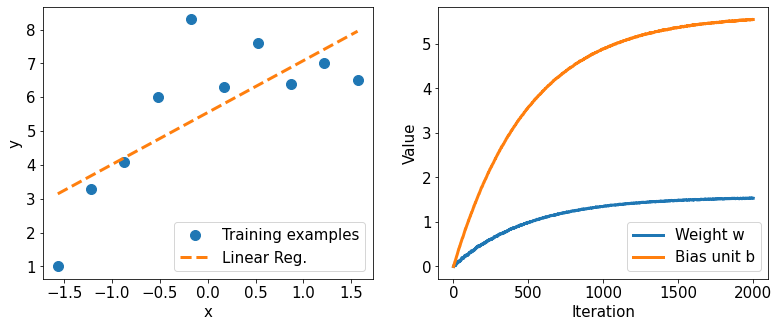

In [11]:
# Cell 10
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

# Fit a parabola
The model above fits
$$
y = wx + b
$$
We'll use tensorflow to fit
$$
y = w_1x + w_2 x^2 + b
$$
* Goal: Walk through code and figure out how to add a trainable parameter
* Need to add a new tensorflow variable during initialization
* Need to modify the "call" method to use the new model

In [12]:
class MyModel2(tf.keras.Model):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b

model2 = MyModel2()

model2.build(input_shape=(None, 1))
model2.summary() # Note how trainable parameters has increased

Model: "my_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [13]:
def train2(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [14]:
# Cell 9
Ws, bs = [], []
num_epochs = 200
log_steps = 10  # NOTE: use 10 to log every epoch; original: 100
learning_rate = 0.001 
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(batch_size)

# Following 2 lines are required if you want to reinitialize model & weights
model2 = MyModel2()
model2.build(input_shape=(None, 1))

for i, batch in enumerate(ds_train):
    if i > steps_per_epoch * num_epochs:
        break
    Ws.append(model2.w.numpy())
    bs.append(model2.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model2(bx), by)

    train2(model2, bx, by, learning_rate=learning_rate)

    if (i%log_steps==0) and (i%100==0):
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 36.0000
Epoch   10 Step 100 Loss 26.2913
Epoch   20 Step 200 Loss 7.2015
Epoch   30 Step 300 Loss 8.0746
Epoch   40 Step 400 Loss 3.0090
Epoch   50 Step 500 Loss 0.8635
Epoch   60 Step 600 Loss 0.4617
Epoch   70 Step 700 Loss 0.1565
Epoch   80 Step 800 Loss 2.4680
Epoch   90 Step 900 Loss 0.2986
Epoch  100 Step 1000 Loss 0.1514
Epoch  110 Step 1100 Loss 3.4157
Epoch  120 Step 1200 Loss 0.0392
Epoch  130 Step 1300 Loss 0.0163
Epoch  140 Step 1400 Loss 0.0481
Epoch  150 Step 1500 Loss 10.1707
Epoch  160 Step 1600 Loss 0.0003
Epoch  170 Step 1700 Loss 1.7608
Epoch  180 Step 1800 Loss 1.7180
Epoch  190 Step 1900 Loss 1.6225
Epoch  200 Step 2000 Loss 9.1236


# Compile and fit

* Instead of `.build` and then training "by hand" (as above)
* Can use numpy arrays instead of tensorflow datasets
* `.fit()` method returns a history object
* Note: Raschka plots "accuracy" for classification problem
    * that metric doesn't make sense for regression
* Once you define the new model, you can simply replace it
    * replace `MyModel` with `MyModel2`

In [15]:
# Cell 11
tf.random.set_seed(1)
model = MyModel2()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse']) 

In [16]:
# Cell 12
history = model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=0)

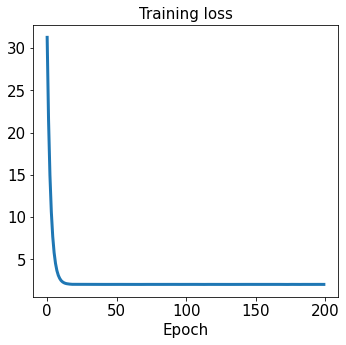

In [17]:
# Cell 21 (modified for this problem -- note we're using `history`)
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()